In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
from loess.loess_1d import loess_1d
from statsmodels.nonparametric.smoothers_lowess import lowess
# from tvregdiff import TVRegDiff
import pandas as pd
from scipy.optimize import curve_fit

In [122]:
def create_exp(N, A, B):
    expo = A*np.exp(-B*np.arange(0,N))
    return expo
def create_lin(N, a, b):
    lin = a*np.arange(0,N) + b
    return lin
def concat_noise(C, m = 0, s = 1):
    # import numpy as np
    concat = []
    for c in C:
        concat.extend(c)
    X = np.arange(0,len(concat))
    Y = concat +  np.random.normal(loc=m, scale=s, size=len(concat))
    return X, Y

def RMSE(Ypred, Yreal):
    rmse = np.sqrt(np.sum(np.square(Ypred-Yreal))/np.shape(Ypred)[0])
    return rmse
def fit_and_pred(X, y):
    
    Xarr = np.array(X).reshape(-1,1)
    yarr = np.array(y).reshape(-1,1)
    reg = LinearRegression().fit(Xarr, yarr)
    pred = reg.predict(Xarr)
    rmse = RMSE(pred, yarr)
    return rmse
def sliding_window_pred(X, y, window, lag):
    Xend = np.shape(X)[0]
    Xmax = np.shape(X)[0]-lag-1
    start = np.arange(window, Xend-window, lag)
   
    mean_start = X[[int(Xend-s) for s in start]]
    # print('lin idx', [int(np.floor((Xend-s+ Xend)/2)) for s in start])
    # print('mean start LIN',mean_start)
    # input()
    score = [fit_and_pred(X[Xend-s:Xend], y[Xend-s:Xend]) 
            for s in start]
    score = min_max(score)
    
    return score, mean_start

# def func(x, a, b):
#     return a * np.exp(-b * x) + c
def func(x, a, b):
    return a * np.exp(-b * x) 

def fit_and_pred_exp(X, y, b, p=False):
    Xarr = np.array(X).reshape(-1)
    yarr = np.array(y).reshape(-1)
    reg = curve_fit(func, Xarr, yarr, bounds=b)[0]
#     A, B, C = reg
    A, B = reg
    if p:
        print('fit: a=%5.3f, b=%5.6f' % tuple(reg))
#     print('fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(reg))
    pred = A * np.exp(-B * Xarr) #+ C
    rmse = RMSE(pred, yarr)
    return rmse

def _detect_b(X, y):
    Xarr = np.array(X).reshape(-1)
    yarr = np.array(y).reshape(-1)
    reg = curve_fit(func, Xarr, yarr)[0]

    return reg

def min_max(X): 
    X_scaled = (X - np.min(X)) / (  np.max(X) -  np.min(X))
    return X_scaled


def sliding_window_exp_pred(X, y, window, lag, b=([9,  0.00001], [11.,  0.001]), p = False):
    Xend = np.shape(X)[0]
    Xmax = np.shape(X)[0]-lag-1
    start = np.arange(window, Xend-window, lag)
    mean_start = X[start ]
    
    reg = _detect_b( X[lag:lag+(window*4)], y[lag:lag+(window*4)])
    A, B = reg 
    bound = ([A-0.1*A,B/10],[A+0.1*A, B*10])
    
    score = [fit_and_pred_exp(X[0:s], y[0:s], b=b, p = p) 
            for s in start if s<=(Xend-window)] 
    
#     score = (score- np.mean(score)) / np.std(score)
    score = min_max(score)  
    return score, mean_start

def dcross(Yl, Ye):
    idx = np.argwhere(np.diff(np.sign(Yl - Ye))).flatten() 
    return idx

def detect_crossing(X, Y, Yexp, Ylin, Xl, Xe):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    Xl=np.array(Xl)  
    Xe=np.array(Xe) 
    idx = dcross(Ylin[::-1], Yexp)
    Xidx=Xe[idx] 
    idx_int = [[i, i+1] for i in idx]
    Xidx_int = [[Xe[i], Xe[i+1] ]for i in idx]
    Yidx=Yexp[idx]
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('time (min)')
    ax1.set_ylabel('sample', color=color)
    ax1.plot(X, Y, color=color, linestyle='-', marker='o', label = 'data')
    color = 'tab:red'
#     ax1.plot(Xselected, Ysmooth, color=color, lw=2, linestyle='-', label = 'smooth')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xl, Ylin, color=color, marker='o', label = 'RMSE lin')
    ax2.tick_params(axis='y', labelcolor=color)
    color = 'tab:orange'
    ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
    ax2.plot(Xe, Yexp, color=color, marker='o', label = 'RMSE exp')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend()
#     for i in np.arange(0,len(idx)):
#         ax2.hlines(Yidx[i], Xidx_int[i][0], Xidx_int[i][1], lw=4, color = 'black')
    plt.plot(Xidx, Yidx, 'ro')
    fig.tight_layout()
    plt.show()
    return idx, Xidx


def detect_crossing_int(Yexp, Ylin, X , plot = False):
    Ylin=np.array(Ylin)
    Yexp=np.array(Yexp)
    X=np.array(X)  
    
    idx = dcross(Ylin, Yexp)
    Xidx=X[idx]    
    idx_int = [[i, i+1] for i in idx]
    Xidx_int = [[X[i], X[i+1] ]for i in idx]
    Yidx=Ylin[idx]

    if plot:
        plt.plot(X, Ylin)
        plt.plot(X, Yexp)
        
        for i in np.arange(0,len(idx)):
            plt.hlines(Yidx[i], Xidx_int[i][0], Xidx_int[i][1], lw=4, color = 'red')
        plt.show()     
        
        print('\nInterval method')
        for i in np.arange(0,len(idx)):
            print('detected changes between times : {} - {}'.format(Xidx_int[i][0], Xidx_int[i][1]))
        
    return idx, Xidx, Xidx_int


# Simulated data

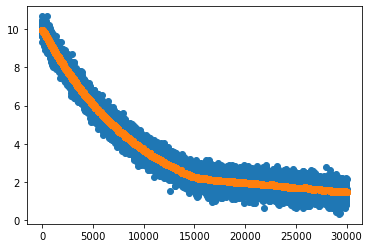

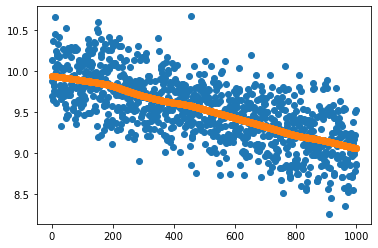

In [105]:
expo = create_exp(N = 15000, A = 10 , B = 0.0001)
lin = create_lin(N = 15000, a = -0.00005 , b = expo[-1]-0.01*expo[-1])

X, Y = concat_noise(C = [expo,lin], m = 0, s = 0.3)
Ysmooth = lowess(exog = X, endog = Y, frac = 0.01, delta = 0.001 * X.shape[0], return_sorted = False)

plt.scatter(X,Y)
plt.scatter(X,Ysmooth)
plt.show()

plt.scatter(X[0:1000],Y[0:1000])
plt.scatter(X[0:1000],Ysmooth[0:1000])
plt.show()

## linear RMSE

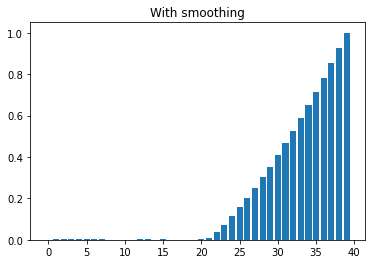

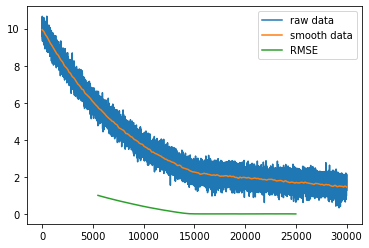

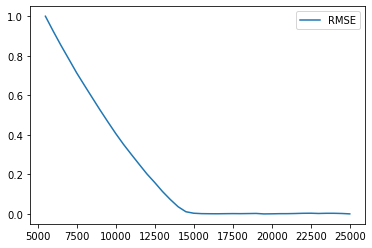

In [123]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()

# plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
# plt.title('With smoothing')
# plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(np.array(score)), label = 'RMSE') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')
plt.legend()
plt.show()


plt.plot(Xscore,(np.array(score)), label = 'RMSE') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')
plt.legend()
plt.show()

In [62]:
print(Xscore)
print(score)

[29500 29491 29482 ...    34    25    16]
[0.00480658 0.00462358 0.00443704 ... 0.997829   0.99891588 1.        ]


## Exponential RMSE

b is a bound parameters for A and B parameters of the exponential function 

this setting can deeply influence non linear regression

/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


fit: a=10.002, b=0.000100
fit: a=10.004, b=0.000100
fit: a=10.004, b=0.000100
fit: a=10.004, b=0.000100
fit: a=10.005, b=0.000100
fit: a=10.003, b=0.000100
fit: a=10.004, b=0.000100
fit: a=10.004, b=0.000100
fit: a=10.003, b=0.000100
fit: a=10.002, b=0.000100
fit: a=10.001, b=0.000100
fit: a=10.001, b=0.000100
fit: a=10.002, b=0.000100
fit: a=10.002, b=0.000100
fit: a=10.002, b=0.000100
fit: a=10.002, b=0.000100
fit: a=10.001, b=0.000100
fit: a=10.000, b=0.000100
fit: a=9.999, b=0.000100
fit: a=9.998, b=0.000100
fit: a=9.997, b=0.000100
fit: a=9.994, b=0.000100
fit: a=9.989, b=0.000100
fit: a=9.979, b=0.000099
fit: a=9.968, b=0.000099
fit: a=9.954, b=0.000099
fit: a=9.938, b=0.000098
fit: a=9.919, b=0.000098
fit: a=9.899, b=0.000097
fit: a=9.880, b=0.000096
fit: a=9.858, b=0.000096
fit: a=9.834, b=0.000095
fit: a=9.811, b=0.000095
fit: a=9.786, b=0.000094
fit: a=9.762, b=0.000093
fit: a=9.737, b=0.000093
fit: a=9.711, b=0.000092
fit: a=9.686, b=0.000091
fit: a=9.661, b=0.000091
fit: a=

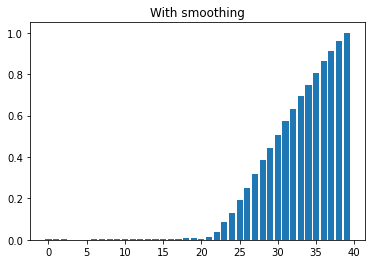

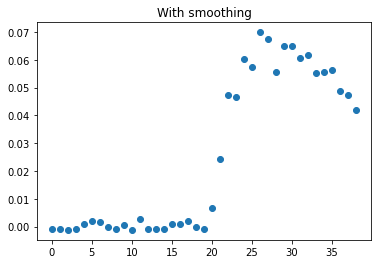

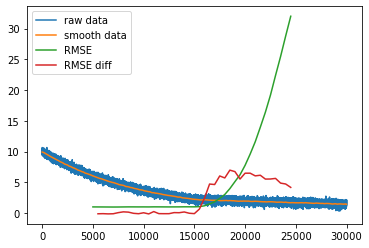

In [124]:
score,Xscore  = sliding_window_exp_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500, b=([9,  0.00001], [11.,  0.001]), p =True)
plt.bar(np.arange(0,np.shape(score)[0]),score)
plt.title('With smoothing')
plt.show()
plt.scatter(np.arange(0,np.shape(np.diff(score))[0]),np.diff(score))
plt.title('With smoothing')
plt.show()

plt.plot(X,Y, label = 'raw data')
plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(1+np.array(score))**5, label = 'RMSE') # amplified in order to have similar scale with raw signal
plt.plot(Xscore[1:],np.diff(score)*100, label = 'RMSE diff')
plt.legend()
plt.show()

## Both linear and exp RMSE

/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


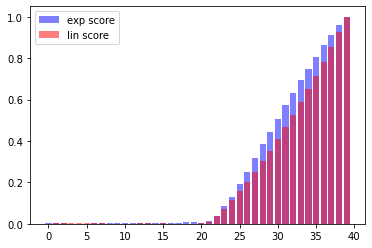

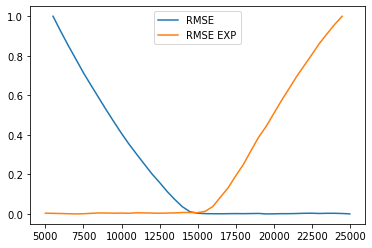

In [125]:
score,Xscore  = sliding_window_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500)

score_exp,Xscore_exp  = sliding_window_exp_pred(X = X, y = Ysmooth, 
                            window = 5000, 
                            lag = 500, b=([9,  0.00001], [11.,  0.001]), p = False)


plt.bar(np.arange(0,len(score_exp)),score_exp, label = 'exp score', fc=(0, 0, 1, 0.5))
plt.bar(np.arange(0,len(score)),score, label = 'lin score', fc=(1, 0, 0, 0.5))
plt.legend()
plt.show()

# plt.plot(X,Y, label = 'raw data')
# plt.plot(X, Ysmooth, label = 'smooth data')
plt.plot(Xscore,(np.array(score)), label = 'RMSE') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')

plt.plot(Xscore_exp,(np.array(score_exp)), label = 'RMSE EXP') # amplified in order to have similar scale with raw signal
# plt.plot(Xscore_exp[1:],np.diff(score_exp), label = 'RMSE diff EXP')
plt.legend()
plt.show()

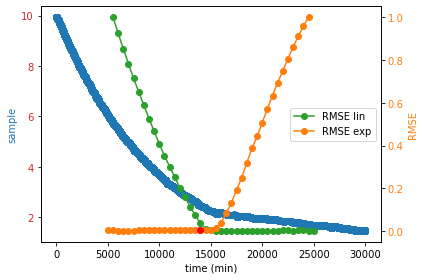

(array([18]), array([14000]))

In [126]:
detect_crossing(X, Ysmooth, Yexp=score_exp,
                Ylin=score, Xl=Xscore, Xe=Xscore_exp)


This is super nice :)

# Real data

['LituBD5_mass', 'LituLD2_mass', 'LituBL2t_mass', 'LituLL21_mass']


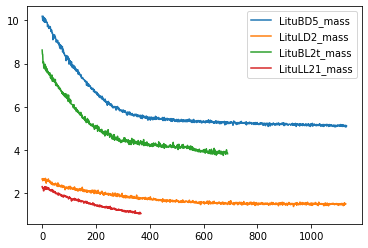

In [127]:
df = pd.read_csv('/home/xavier/Documents/development/DetectEvent/data/time series_dehydration.csv', sep = ",")
df.head()
col = [c for c in df.columns if c != 'time_min']
print(col)
df[col].plot()

test for LituBD5_mass -------------------------------
fit: a=10.218, b=0.000540
fit: a=10.194, b=0.000531
fit: a=10.163, b=0.000520
fit: a=10.126, b=0.000509
fit: a=10.082, b=0.000495
fit: a=10.031, b=0.000481
fit: a=9.975, b=0.000466
fit: a=9.915, b=0.000451
fit: a=9.851, b=0.000435
fit: a=9.783, b=0.000419
fit: a=9.712, b=0.000403
fit: a=9.639, b=0.000388
fit: a=9.565, b=0.000373
fit: a=9.492, b=0.000358
fit: a=9.419, b=0.000345
fit: a=9.346, b=0.000331
fit: a=9.273, b=0.000318
fit: a=9.202, b=0.000306
fit: a=9.131, b=0.000294
fit: a=9.061, b=0.000283
fit: a=8.993, b=0.000272
fit: a=8.926, b=0.000262
fit: a=8.861, b=0.000252
fit: a=8.798, b=0.000243
fit: a=8.736, b=0.000235
fit: a=8.676, b=0.000226
fit: a=8.618, b=0.000219
fit: a=8.561, b=0.000211
fit: a=8.506, b=0.000204
fit: a=8.452, b=0.000197
fit: a=8.399, b=0.000191


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


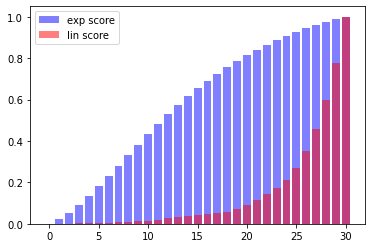

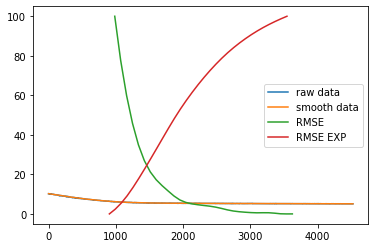

test for LituLD2_mass -------------------------------
fit: a=2.593, b=0.000321
fit: a=2.585, b=0.000310
fit: a=2.577, b=0.000301
fit: a=2.571, b=0.000293
fit: a=2.564, b=0.000286
fit: a=2.558, b=0.000280
fit: a=2.552, b=0.000274
fit: a=2.546, b=0.000268
fit: a=2.539, b=0.000262
fit: a=2.533, b=0.000257
fit: a=2.527, b=0.000252
fit: a=2.521, b=0.000248
fit: a=2.515, b=0.000243
fit: a=2.508, b=0.000239
fit: a=2.501, b=0.000234
fit: a=2.495, b=0.000230
fit: a=2.487, b=0.000225
fit: a=2.480, b=0.000221
fit: a=2.473, b=0.000217
fit: a=2.465, b=0.000212
fit: a=2.457, b=0.000208
fit: a=2.449, b=0.000204
fit: a=2.441, b=0.000199
fit: a=2.432, b=0.000195
fit: a=2.423, b=0.000190
fit: a=2.414, b=0.000186
fit: a=2.405, b=0.000182
fit: a=2.396, b=0.000177
fit: a=2.387, b=0.000173
fit: a=2.377, b=0.000169
fit: a=2.368, b=0.000165


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


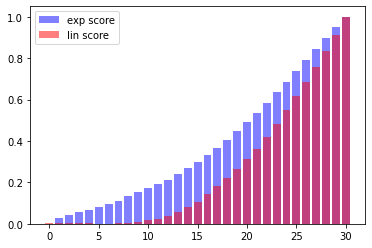

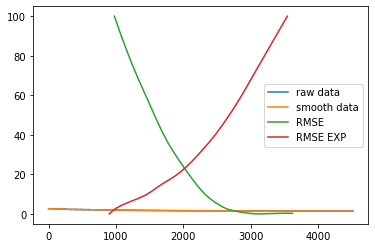

test for LituBL2t_mass -------------------------------
fit: a=8.058, b=0.000625
fit: a=8.057, b=0.000624
fit: a=8.054, b=0.000623
fit: a=8.049, b=0.000620
fit: a=8.041, b=0.000615
fit: a=8.029, b=0.000608
fit: a=8.013, b=0.000600
fit: a=7.995, b=0.000591
fit: a=7.975, b=0.000581
fit: a=7.953, b=0.000571
fit: a=7.930, b=0.000561
fit: a=7.908, b=0.000551
fit: a=7.884, b=0.000542
fit: a=7.858, b=0.000531
fit: a=7.829, b=0.000520
fit: a=7.797, b=0.000508
fit: a=7.763, b=0.000496
fit: a=7.728, b=0.000484
fit: a=7.692, b=0.000473
fit: a=7.657, b=0.000461
fit: a=7.621, b=0.000450
fit: a=7.585, b=0.000439
fit: a=7.549, b=0.000428
fit: a=7.513, b=0.000418
fit: a=7.477, b=0.000407
fit: a=7.441, b=0.000397
fit: a=7.405, b=0.000388
fit: a=7.369, b=0.000378
fit: a=7.333, b=0.000369
fit: a=7.297, b=0.000360
fit: a=7.261, b=0.000351
fit: a=7.226, b=0.000343


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


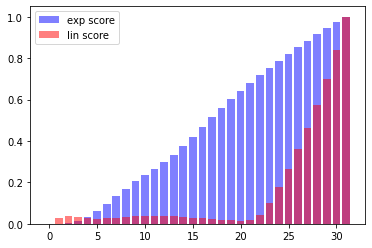

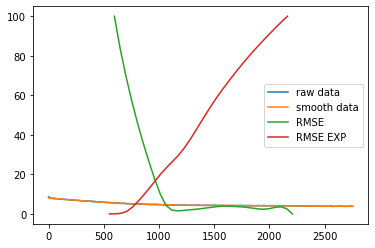

test for LituLL21_mass -------------------------------
fit: a=2.292, b=0.000638
fit: a=2.293, b=0.000642
fit: a=2.293, b=0.000641
fit: a=2.292, b=0.000638
fit: a=2.291, b=0.000635
fit: a=2.291, b=0.000635
fit: a=2.291, b=0.000634
fit: a=2.290, b=0.000631
fit: a=2.288, b=0.000625
fit: a=2.286, b=0.000619
fit: a=2.283, b=0.000612
fit: a=2.281, b=0.000606
fit: a=2.279, b=0.000600
fit: a=2.277, b=0.000596
fit: a=2.275, b=0.000592
fit: a=2.273, b=0.000588
fit: a=2.272, b=0.000586
fit: a=2.271, b=0.000583
fit: a=2.270, b=0.000581
fit: a=2.268, b=0.000579
fit: a=2.267, b=0.000576
fit: a=2.266, b=0.000574
fit: a=2.265, b=0.000572
fit: a=2.264, b=0.000570
fit: a=2.262, b=0.000568
fit: a=2.261, b=0.000566
fit: a=2.260, b=0.000564
fit: a=2.259, b=0.000562
fit: a=2.258, b=0.000560
fit: a=2.256, b=0.000558
fit: a=2.255, b=0.000557
fit: a=2.254, b=0.000555


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


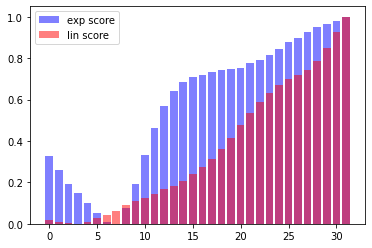

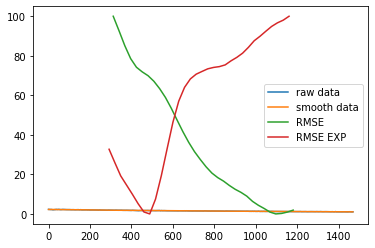

In [128]:
#extracted from third iteration and then refitted can be automatized later

Bound = [([10.041-2,0.0000503],[10.041+2,0.00503]), #a=5.504, b=0.000016
         ([2.508-2,0.0000262],[2.508+2,0.00262]), #  a=2.000, b=0.000072
         ([8.037-2,0.0000618],[8.037+2,0.00618]), #a=5.119, b=0.000107
         ([2.314-2,0.0000681],[2.314+2,0.00681])] #a=2.000, b=0.000436

i = 0
for c in col:
    
    print('test for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    
    
    score,Xscore  = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50))

    score_exp,Xscore_exp  = sliding_window_exp_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50), b= Bound[i], p = True)
    i+=1
    plt.bar(np.arange(0,len(score_exp)),score_exp, label = 'exp score', fc=(0, 0, 1, 0.5))
    plt.bar(np.arange(0,len(score)),score, label = 'lin score', fc=(1, 0, 0, 0.5))
    plt.legend()
    plt.show()

    plt.plot(df2['time_min'].values,df2[c].values, label = 'raw data')
    plt.plot(df2['time_min'].values, Ysmooth, label = 'smooth data')
    plt.plot(Xscore,np.array(score)*100, label = 'RMSE') # amplified in order to have similar scale with raw signal
#     plt.plot(Xscore[1:],np.diff(score), label = 'RMSE diff')

    plt.plot(Xscore_exp,np.array(score_exp)*100, label = 'RMSE EXP') # amplified in order to have similar scale with raw signal
#     plt.plot(Xscore_exp[1:],np.diff(score_exp), label = 'RMSE diff EXP')
    plt.legend()
    plt.show()


test for LituBD5_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


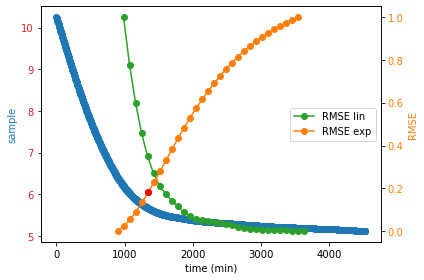


test for LituLD2_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


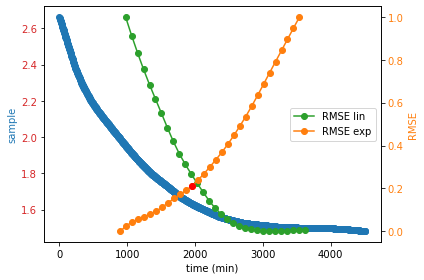


test for LituBL2t_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


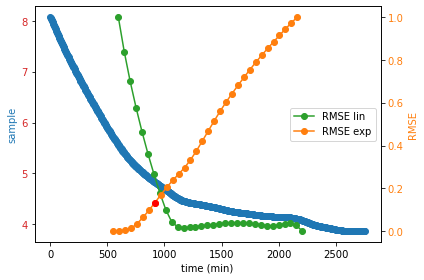


test for LituLL21_mass -------------------------------


/home/xavier/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


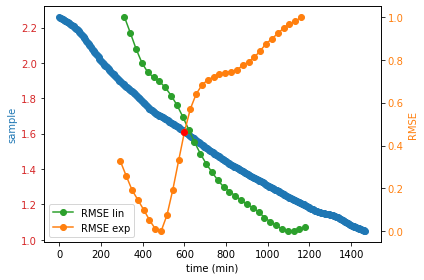

In [129]:
#extracted from third iteration and then refitted can be automatized later

Bound = [([10.041-2,0.0000503],[10.041+2,0.00503]), #a=5.504, b=0.000016
         ([2.508-2,0.0000262],[2.508+2,0.00262]), #  a=2.000, b=0.000072
         ([8.037-2,0.0000618],[8.037+2,0.00618]), #a=5.119, b=0.000107
         ([2.314-2,0.0000681],[2.314+2,0.00681])] #a=2.000, b=0.000436

i = 0
for c in col:
    
    print('\ntest for {} -------------------------------'.format(c))
    df2 = df[['time_min', c]].dropna(subset = [c])
    Ysmooth = lowess(exog = df2['time_min'].values, endog = df2[c].values, frac = 0.1, delta = 0.1 * df2['time_min'].shape[0], return_sorted = False)
    
    
    score,Xscore  = sliding_window_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50))

    score_exp,Xscore_exp  = sliding_window_exp_pred(X = df2['time_min'].values, y = Ysmooth, 
                            window = int(df2[c].shape[0]/5), 
                            lag = int(df2[c].shape[0]/50), b= Bound[i], p = False)
    i+=1
    detect_crossing(df2['time_min'].values, Ysmooth, Yexp=score_exp,
                    Ylin=score, Xl=Xscore, Xe=Xscore_exp)
